In [1]:
import os
# import codecs
from keras.models import Sequential
from keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

import missingno as msno

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./korea_apartment.csv', encoding='utf-8')
df.tail()

C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,city,district,dong,apartment,m2,price,floor,contract_date,pre_m2,moving_date,pre_date,pre_price,num_people,people_by_m2,price_by_m2,price_by_pre_m2,price_by_pre_price
6174900,충청북도,제천시,청전동,주공1차,42.54,"1,700",1.0,2018.11,42.98,1980.11,NaN,NaN,640,250,132,131,NaN
6174901,충청북도,보은군,마로면,조일,50.19,"1,700",3.0,2018.09,58.94,1985.11,NaN,NaN,40,40,112,95,NaN
6174902,충청북도,보은군,마로면,조일,50.19,"1,700",3.0,2018.10,58.94,1985.11,NaN,NaN,40,40,112,95,NaN
6174903,충청북도,제천시,청전동,주공1차,41.99,"1,700",5.0,2018.10,42.98,1980.11,NaN,NaN,640,100,134,131,NaN
6174904,충청북도,제천시,청전동,주공1차,41.56,"1,500",5.0,2018.07,42.98,1980.11,NaN,NaN,640,50,119,115,NaN


In [3]:
# epoch에 따라 learning rate에 변화를 주기 위한 함수
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 100:
        lrate = 0.005
    if epoch > 150:
        lrate = 0.003
    if epoch > 200:
        lrate = 0.001
    return lrate

city : 0
district : 0
dong : 0
apartment : 0
m2 : 0
price : 0
floor : 5
contract_date : 0
pre_m2 : 0
moving_date : 0
pre_date : 3665424
pre_price : 2704792
num_people : 0
people_by_m2 : 110
price_by_m2 : 7404
price_by_pre_m2 : 0
price_by_pre_price : 2704800
AxesSubplot(0.125,0.125;0.698618x0.755)


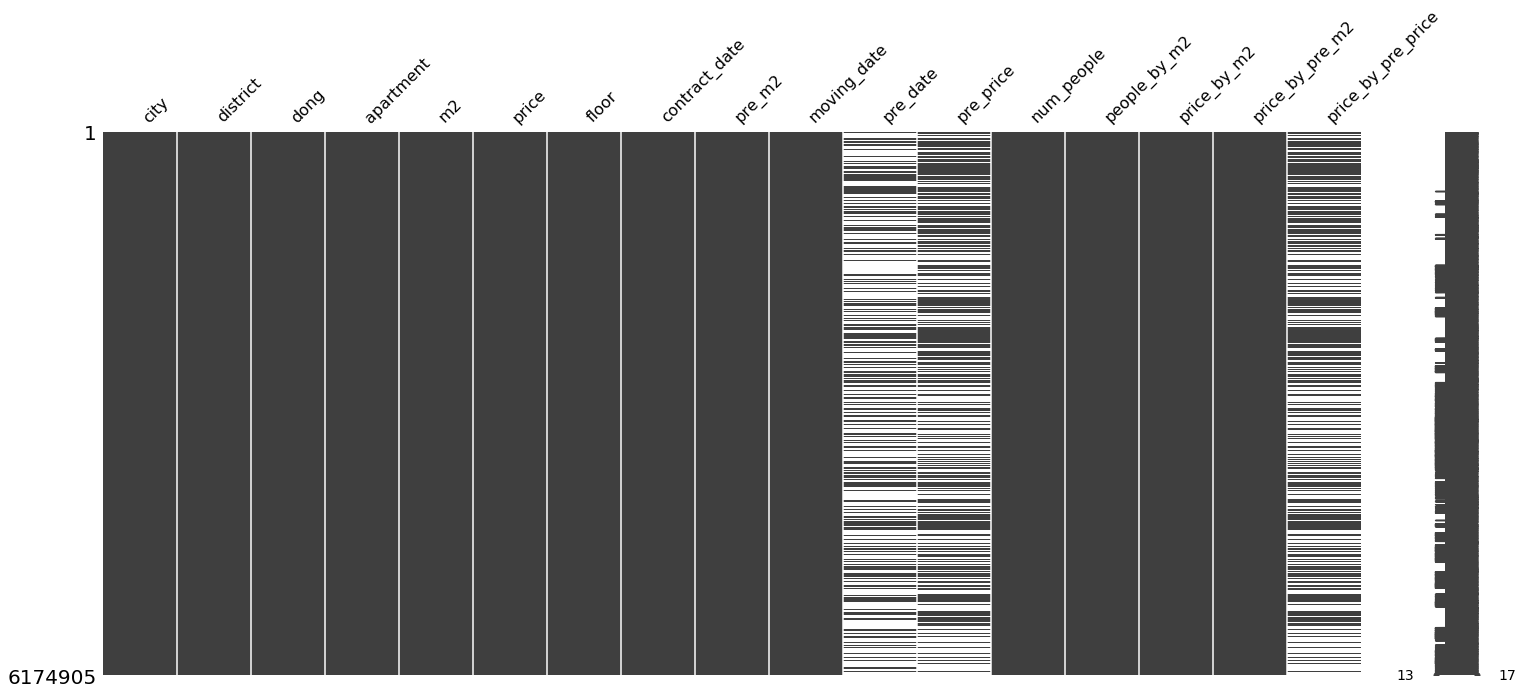

In [4]:
for c in df.columns:
    print('{} : {}'.format(c, len(df.loc[pd.isnull(df[c]),c].values)))
print(msno.matrix(df))

In [5]:
# 도시, 행정구, 동,아파트를 라벨 인코딩 함
le = LabelEncoder()
list1 = ['city', 'district', 'dong', 'apartment']
for i in list1:
    temp = df[i].to_frame()
    df[i] = temp.apply(le.fit_transform)
    
df['year'] = df['contract_date'].apply(lambda x: str(x)[:4]).astype(str)
df['month'] = df['contract_date'].apply(lambda x: str(x)[5:7]).astype(str)
del df['contract_date']
df.tail()

,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,pre_date,pre_price,num_people,people_by_m2,price_by_m2,price_by_pre_m2,price_by_pre_price,year,month
6174900,16,171,1723,13054,42.54,"1,700",1.0,42.98,1980.11,NaN,NaN,640,250,132,131,NaN,2018,11
6174901,16,75,519,13008,50.19,"1,700",3.0,58.94,1985.11,NaN,NaN,40,40,112,95,NaN,2018,09
6174902,16,75,519,13008,50.19,"1,700",3.0,58.94,1985.11,NaN,NaN,40,40,112,95,NaN,2018,1
6174903,16,171,1723,13054,41.99,"1,700",5.0,42.98,1980.11,NaN,NaN,640,100,134,131,NaN,2018,1
6174904,16,171,1723,13054,41.56,"1,500",5.0,42.98,1980.11,NaN,NaN,640,50,119,115,NaN,2018,07


In [6]:
df.head()

,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,pre_date,pre_price,num_people,people_by_m2,price_by_m2,price_by_pre_m2,price_by_pre_price,year,month
0,8,1,1156,1504,196.21,"450,000",13.0,211.23,1976.06,NaN,NaN,480,120,"7,582","7,043",NaN,2018,12
1,8,1,1706,4942,202.58,"450,000",5.0,252.31,2010.07,2009.05,"600,000",19,1,"7,343","5,896","7,861",2018,12
2,8,1,1156,9746,139.83,"320,000",7.0,165.29,1982.04,NaN,NaN,"1,924",168,"7,565","6,400",NaN,2018,12
3,8,1,393,15322,191.04,"315,000",2.0,219.22,1983.12,NaN,"8,978","1,204",84,"5,451","4,750",135,2018,12
4,8,1,1156,1509,144.20,"304,000",10.0,158.68,1979.05,NaN,NaN,560,168,"6,969","6,333",NaN,2018,12


In [7]:
list = ['price','pre_price','num_people','people_by_m2','price_by_m2','price_by_pre_m2','price_by_pre_price']
for i in list:
    df[i] = df[i].apply(lambda x: str(x).replace('nan',"0"))
    df[i] = df[i].apply(lambda x: float(x.replace(",","")))

In [8]:
# 분양일은 절반 이상 비어있고, 아파트 단지별로 분양일이 비슷할걸로 생각해서 그냥 지움
del df['pre_date']
# 분양가와 평당 분양가는 1/4정도 비어있지만, 일단 지움
del df['pre_price']
del df['price_by_pre_price']
df.tail()

,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
6174900,16,171,1723,13054,42.54,1700.0,1.0,42.98,1980.11,640.0,250.0,132.0,131.0,2018,11
6174901,16,75,519,13008,50.19,1700.0,3.0,58.94,1985.11,40.0,40.0,112.0,95.0,2018,09
6174902,16,75,519,13008,50.19,1700.0,3.0,58.94,1985.11,40.0,40.0,112.0,95.0,2018,1
6174903,16,171,1723,13054,41.99,1700.0,5.0,42.98,1980.11,640.0,100.0,134.0,131.0,2018,1
6174904,16,171,1723,13054,41.56,1500.0,5.0,42.98,1980.11,640.0,50.0,119.0,115.0,2018,07


In [9]:
df.dropna()

,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
0,8,1,1156,1504,196.21,450000.0,13.0,211.23,1976.06,480.0,120.0,7582.0,7043.0,2018,12
1,8,1,1706,4942,202.58,450000.0,5.0,252.31,2010.07,19.0,1.0,7343.0,5896.0,2018,12
2,8,1,1156,9746,139.83,320000.0,7.0,165.29,1982.04,1924.0,168.0,7565.0,6400.0,2018,12
3,8,1,393,15322,191.04,315000.0,2.0,219.22,1983.12,1204.0,84.0,5451.0,4750.0,2018,12
4,8,1,1156,1509,144.20,304000.0,10.0,158.68,1979.05,560.0,168.0,6969.0,6333.0,2018,12
5,8,1,1019,416,165.43,300000.0,8.0,202.20,2016.08,400.0,4.0,5995.0,4905.0,2018,12
6,8,1,393,4554,94.49,280000.0,16.0,126.22,2015.09,1608.0,230.0,9796.0,7333.0,2018,12
7,8,1,393,3830,145.83,279000.0,20.0,177.35,2005.01,805.0,386.0,6325.0,5201.0,2018,12
8,8,1,1706,13830,191.59,250000.0,6.0,290.91,2005.09,12.0,2.0,4314.0,2841.0,2018,12
9,8,1,307,4030,160.33,240000.0,14.0,194.26,2004.07,203.0,23.0,4948.0,4084.0,2018,12


In [10]:
for c in df.columns:
    print('{} : {}'.format(c, len(df.loc[pd.isnull(df[c]),c].values)))

city : 0
district : 0
dong : 0
apartment : 0
m2 : 0
price : 0
floor : 5
pre_m2 : 0
moving_date : 0
num_people : 0
people_by_m2 : 0
price_by_m2 : 0
price_by_pre_m2 : 0
year : 0
month : 0


In [11]:
df = df[df['floor'].isnull() == False]

In [12]:
df.to_csv("preprocessed_apartment.csv", index=False)

In [13]:
check = pd.read_csv("./preprocessed_apartment.csv")

In [14]:
for c in check.columns:
    print('{} : {}'.format(c, len(df.loc[pd.isnull(df[c]),c].values)))

city : 0
district : 0
dong : 0
apartment : 0
m2 : 0
price : 0
floor : 0
pre_m2 : 0
moving_date : 0
num_people : 0
people_by_m2 : 0
price_by_m2 : 0
price_by_pre_m2 : 0
year : 0
month : 0


In [15]:
check.head()

,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
0,8,1,1156,1504,196.21,450000.0,13.0,211.23,1976.06,480.0,120.0,7582.0,7043.0,2018,12
1,8,1,1706,4942,202.58,450000.0,5.0,252.31,2010.07,19.0,1.0,7343.0,5896.0,2018,12
2,8,1,1156,9746,139.83,320000.0,7.0,165.29,1982.04,1924.0,168.0,7565.0,6400.0,2018,12
3,8,1,393,15322,191.04,315000.0,2.0,219.22,1983.12,1204.0,84.0,5451.0,4750.0,2018,12
4,8,1,1156,1509,144.20,304000.0,10.0,158.68,1979.05,560.0,168.0,6969.0,6333.0,2018,12
